# Read the Data

In [1]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df_main = pd.read_csv('xtrain.txt', header = None, sep = '\t')
df_main.set_index(0, inplace = True)
df_main = df_main.transpose()
df_main.index


# Read the y values
df_y = pd.read_csv('ytrain.txt', header = None)
df_y.index = 1+np.arange(184)

# Concatenate both
df_main['y'] = df_y[0:]
df_main = df_main.astype({'y':'category'})

df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 1 to 184
Columns: 4655 entries, x10006_at to y
dtypes: category(1), float64(4654)
memory usage: 6.5 MB


In [3]:
# Save the data
# df_main.to_csv('breast_genes.csv', index = False)

# Applying Different Models

In [4]:
x = df_main.drop(['y'], axis = 1).values
y = np.array(df_main.y.values)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [5]:
# Random Forest with default number of estimators
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(rf.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.688524590164


0.61270022883295194

In [6]:
# RandomForest with 100 estimators
rf = RandomForestClassifier(n_estimators= 100, random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(rf.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.622950819672


0.50858123569794056

In [7]:
# SVM with default parameters
clf = SVC(random_state=42)
clf.fit(x_train, y_train)
len(clf.support_vectors_)
pred = clf.predict(x_test)
print(clf.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.622950819672


0.5

In [8]:
# SVM with default parameters
clf = LinearSVC(random_state=42)
clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))
pred = clf.predict(x_test)
roc_auc_score(y_test, pred)

0.704918032787


0.66018306636155599

In [9]:
# Logistic Regression with default parameters
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
print(lr.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.737704918033


0.69508009153318084

In [10]:
# Logistic Regression with dual form 
lr = LogisticRegression(random_state=42, dual =True) # best one till now
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
print(lr.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.770491803279


0.75572082379862704

In [44]:
# Logistic Regression with C = 0.01
# C : Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization.

lr = LogisticRegression(random_state=42, C = 0.01)
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
print(lr.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.737704918033


0.70366132723112118

In [12]:
# KNN with default params
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
print(knn.score(x_test, y_test))
roc_auc_score(y_test, pred)

0.524590163934


0.45537757437070936

In [13]:
# SVM with polynomial kernel
clf = SVC(random_state=42 , C = 10, kernel = 'poly') # (sigmoid 62) and (rbf 65), (poly 70)
clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))
print(len(clf.support_vectors_))
pred = clf.predict(x_test)
roc_auc_score(y_test, pred)

0.704918032787
112


0.66018306636155599

# Hyperparams Tuning for SVM

In [14]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
#     gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    degrees = [2, 3, 4, 5]
    param_grid = {'C': Cs, 'kernel' : kernels, 'degree': degrees}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [15]:
# takes 4 min to run
# best_params = svc_param_selection(x, y, 10)
# best_params # were {'C': 10, 'degree': 2, 'kernel': 'rbf'}

In [16]:
clf = SVC(random_state=42 , C = 10, kernel = 'rbf')
clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))
len(clf.support_vectors_)
pred = clf.predict(x_test)
roc_auc_score(y_test, pred)

0.655737704918


0.5778032036613272

In [17]:
clf = SVC(random_state=42 , C = 10, kernel = 'poly', degree = 7) 
clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))
len(clf.support_vectors_)
pred = clf.predict(x_test)
roc_auc_score(y_test, pred)

0.754098360656


0.71681922196796333

# Genetic Algorithm for choosing the best pipeline

In [18]:
# from tpot import TPOTClassifier

In [19]:
# auto_ml = TPOTClassifier(generations = 20, population_size = 100, scoring = 'balanced_accuracy', n_jobs = 4, random_state = 42, warm_start = True, verbosity = 2)
# auto_ml.fit(x_train, y_train)

In [20]:
# auto_ml.export('tpot_exported_pipeline.py')

In [21]:
# Best pipeline: 
# DecisionTreeClassifier(Normalizer(input_matrix, norm=max), criterion=gini, max_depth=6, min_samples_leaf=4, min_samples_split=4)

# Visualization

 ## PCA

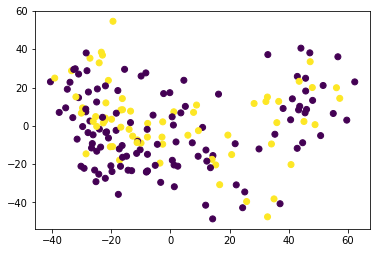

In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)

df = df_main.copy()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]


plt.scatter(df['pca-one'], df['pca-two'], c = df['y'])

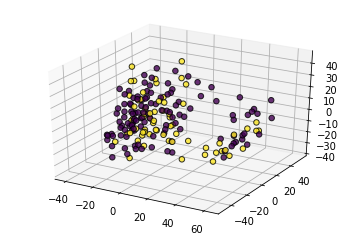

In [23]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['pca-one'], df['pca-two'], df['pca-three'], alpha=0.8, c=df.y, edgecolors='none', s=30)

In [69]:
## t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.000s...
[t-SNE] Computed neighbors for 184 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 11.953017
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.876190
[t-SNE] KL divergence after 300 iterations: 0.723309


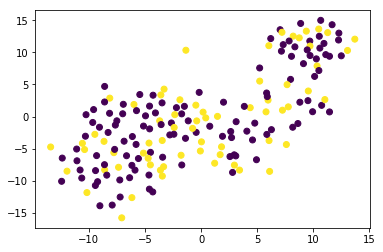

In [76]:
n_sne = 7000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.drop(['y'], axis = 1).values)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c = df['y'])

In [77]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax = fig.gca(projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], alpha=0.8, c=df.y, edgecolors='none', s=30)

In [70]:
## ISOMAP

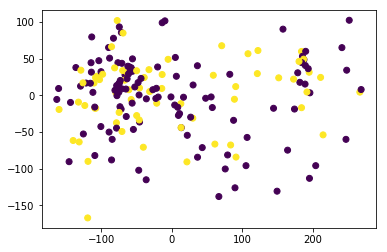

In [78]:
n_neighbors = 10
n_components = 2
y_iso = Isomap(n_neighbors, n_components).fit_transform(x)

ax = fig.add_subplot(111)
plt.scatter(y_iso[:, 0], y_iso[:, 1], c=y)#, cmap=plt.cm.Spectral)
# plt.title("Isomap on S curve")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.show()

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.manifold import Isomap

from sklearn import datasets

n_points = 1000

# S dataset

X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2
X.shape

(1000, 3)

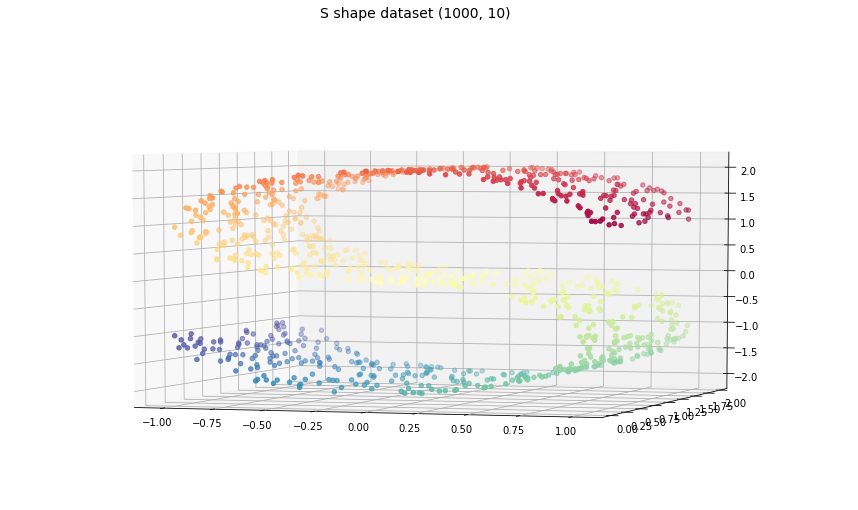

In [73]:
%matplotlib inline
fig = plt.figure(figsize=(15, 8))

plt.suptitle(f'S shape dataset {(1000, n_neighbors)}', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Feature selection

## F-Test

F-Test is useful in feature selection as we get to know the significance of each feature in improving the model.

In [30]:
F, pval = f_classif(x, y)
F

array([  0.2516447 ,   1.83626539,   3.83136621, ...,  10.94496781,
         1.09204361,   0.35240889])

In [31]:
idx = np.argsort(-F)
idx

array([2527, 2776,  162, ..., 3716, 2460, 3533])

In [32]:
df_new = df_main.iloc[:,idx[0:1000]]
df_new['y'] = df_y[0:]

x_red = df_new.drop(['y'], axis = 1).values
y_red = np.array(df_new.y.values)

x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

In [33]:
lr = LogisticRegression(random_state=42, dual =True) # best one till now
lr.fit(x_train_red, y_train_red)
pred = lr.predict(x_test_red)
print(lr.score(x_test_red, y_test_red))
roc_auc_score(y_test_red, pred)

0.819672131148


0.81235697940503426

In [34]:
# num_feats = np.linspace(100, 3000, 30)

# for f in num_feats:
#     df_new = df_main.iloc[:,idx[0:int(f)]]
#     df_new['y'] = df_y[0:]

#     x_red = df_new.drop(['y'], axis = 1).values
#     y_red = np.array(df_new.y.values)

#     x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x, y, test_size=0.33, random_state=42)

#     lr = LogisticRegression(random_state=42, dual =True) # best one till now
#     lr.fit(x_train_red, y_train_red)
#     pred = lr.predict(x_test_red)
#     print(f'for num_feats = {f} - Accuracy = {lr.score(x_test, y_test):.4f} - ROC = {roc_auc_score(y_test, pred):.4f}')


## Mututal Information

In [35]:
mi = mutual_info_classif(x, y)

In [36]:
mi.shape

(4654,)

In [37]:
idx_mi = np.argsort(-mi)
idx_mi

array([3985, 4462, 1753, ..., 1518, 3120,    0])

In [43]:
# df_new = df_main.iloc[:,idx_mi[0:100]]
# df_new['y'] = df_y[0:]

# x_red = df_new.drop(['y'], axis = 1).values
# y_red = np.array(df_new.y.values)

# x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

# lr = LogisticRegression(random_state=42, dual =True) # best one till now
# lr.fit(x_train_red, y_train_red)
# pred = lr.predict(x_test_red)
# print(lr.score(x_test_red, y_test_red))
# roc_auc_score(y_test_red, pred)

0.622950819672


0.65446224256292906

## Variance Threshold

In [50]:
from sklearn.feature_selection import VarianceThreshold

In [53]:
sel = VarianceThreshold()
selected_feats = sel.fit_transform(x)

In [54]:
selected_feats.shape

(184, 4654)

# Feature Engineering

In [26]:
import featuretools as ft

In [27]:
df = df.reset_index()

In [28]:
es = ft.EntitySet(id='main_df')

In [29]:
es = es.entity_from_dataframe(entity_id= 'main_df', dataframe=df)#, make_index=False)

2019-01-30 13:55:50,159 featuretools.entityset - WARNING    ('Using first column as index. ', 'To change this, specify the index parameter')
